# Inference Scenarios

## (Demo: Resnet50_v1 for ImageNet2012)

  1. serve the model
  
  2. interceptor preprocess and forward invocations
  
  3. track information by scanflow
  

In [9]:
!pip install alibi seldon_core

  Using cached seldon_core-1.7.0-py3-none-any.whl (129 kB)


     |████████████████████████████████| 3.2 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 72 kB 1.0 MB/s  eta 0:00:01
     |████████████████████████████████| 127 kB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 2.8 MB/s eta 0:00:011
     |████████████████████████████████| 59 kB 6.2 MB/s  eta 0:00:01


  Created wheel for Flask-OpenTracing: filename=Flask_OpenTracing-1.1.0-py3-none-any.whl size=9071 sha256=fa41e8902b443f5c67bd63443015867bd4f9a10a7a82e0054db8567f56502bb4
  Stored in directory: /gpfs/bsc_home/xpliu/.cache/pip/wheels/f2/fc/27/9dd7ae47db91620be849e6479d5f3d44005a1304b70906d2b0
  Created wheel for grpcio-reflection: filename=grpcio_reflection-1.32.0-py3-none-any.whl size=14412 sha256=30871a7611ccd238ca4e2eacc92a0581b080b468d88e62fe00f4e02c36500518
  Stored in directory: /gpfs/bsc_home/xpliu/.cache/pip/wheels/6b/a3/2a/932100f4e93c50a5c9cb23c56d2ac1de443967f336bbaa923d
  Created wheel for jaeger-client: filename=jaeger_client-4.4.0-py3-none-any.whl size=64325 sha256=248e2c8e34f1e0b3aad1d841441e64835eea2a07ba916900231267075066e4c1
  Stored in directory: /gpfs/bsc_home/xpliu/.cache/pip/wheels/7c/24/9f/aa50e02a45573e67c56f238f0954a07ca001de04472141186b
  Created wheel for opentracing: filename=opentracing-2.4.0-py3-none-any.whl size=51400 sha256=442796e2c81e56f79d1dca07336717a

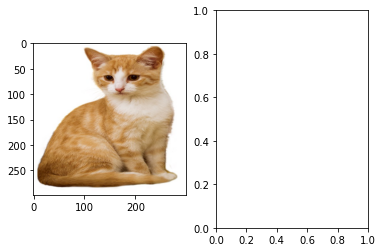

In [1]:
from PIL import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions
import alibi
from alibi.datasets import fetch_imagenet
import numpy as np

def get_image_data():
    data = []
    image_shape = (299, 299, 3)
    target_size = image_shape[:2]
    image = Image.open("cat.jpg").convert('RGB')
    image = np.expand_dims(image.resize(target_size), axis=0)
    data.append(image)
    data = np.concatenate(data, axis=0)
    return data

data = get_image_data()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data[0])
plt.show()

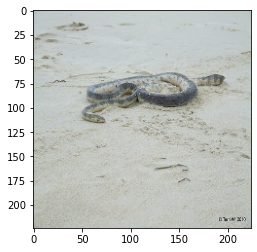

In [35]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread('./data_imagenet/val/ILSVRC2012_val_00000001.JPEG')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="image",namespace="resnet-tf-graph", \
                  grpc_max_send_message_length= 27 * 1024 * 1024, \
                  grpc_max_receive_message_length= 27 * 1024 * 1024)

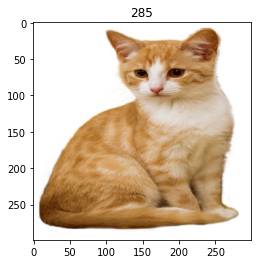

In [20]:
import tensorflow as tf
data = get_image_data()
# print(type(data))
req = data[0:1]
# print(type(req))
# print(req)
r = sc.predict(gateway="istio",transport="grpc", \
               gateway_endpoint="172.30.0.50:40000", \
               data=req,payload_type='tftensor')
# print(r)

label = np.argmax(r.response['data']['tftensor']['floatVal'], axis=0)
plt.title(label)
plt.imshow(data[0])

In [ ]:
import tensorflow as tf
data = get_image_data()
# print(type(data))
req = data[0:1]
# print(type(req))
# print(req)
r = sc.predict(gateway="istio",transport="grpc", \
               gateway_endpoint="172.30.0.50:40000", \
               data=req,payload_type='tftensor',client_return_type="proto")
# print(r)

preds = tf.make_ndarray(r.response.data.tftensor)
label = decode_predictions(preds, top=1)
plt.title(label[0])
plt.imshow(data[0])

In [33]:
import json
import os
import sys
image_list_inmemory = {}
image_list_inmemory[0] = np.load('ILSVRC2012_val_00050000.JPEG.npy')
image_list_inmemory[1] = np.load('ILSVRC2012_val_00050000.JPEG.npy')
# print(image_list_inmemory)


data = np.array([image_list_inmemory[id] for id in [0,1]])
print(np.size(data))
print(len(data))
# print(type(np.load('ILSVRC2012_val_00050000.JPEG.npy')))
# req = np.array([np.load('ILSVRC2012_val_00050000.JPEG.npy')])
# print(type(req))
# req = json.dumps(req.tolist())
# print(type(req))
# print(req)
r = sc.predict(gateway="istio",transport="grpc", \
               gateway_endpoint="172.30.0.50:40000", \
               data=data,payload_type='tftensor',client_return_type="proto")

preds = tf.make_ndarray(r.response.data.tftensor)
# print(preds[0])

arglabel = np.argmax(preds[0], axis=0)
print(arglabel)

label = decode_predictions(preds, top=1)
print(label)
# print(len(r))

# label = np.argmax(r.response['data']['tftensor']['floatVal'], axis=0)
# plt.title(label)
# plt.imshow(data[0])
# plt.imshow(data[1])

301056
2
355
[[('n02437616', 'llama', 0.91163546)], [('n02437616', 'llama', 0.9116356)]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


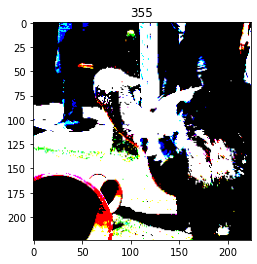

In [38]:
image_list_inmemory = {}
image_list_inmemory[0] = np.load('ILSVRC2012_val_00050000.JPEG.npy')
# print(image_list_inmemory)


data = np.array([image_list_inmemory[0],image_list_inmemory[0]])
# print(data)

req = np.array([np.load('./preprocessed/imagenet/NHWC/val/ILSVRC2012_val_00050000.JPEG.npy')])
# print(req)
r = sc.predict(gateway="istio",transport="grpc", \
               gateway_endpoint="172.30.0.50:40000", \
               data=req,payload_type='tftensor')

label = np.argmax(r.response['data']['tftensor']['floatVal'], axis=0)
plt.title(label)
plt.imshow(data[0])
# plt.imshow(data[1])

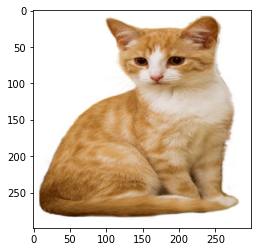

In [28]:
plt.imshow(data[0])

#### explaination

In [29]:
req = np.expand_dims(data[0], axis=0)
# print(req)
explanation = sc.explain(gateway="istio",transport="rest", \
                         gateway_endpoint="172.30.0.50:40000", \
                         predictor="default", payload_type='tftensor', client_return_type="proto")
#http://172.30.0.53:40000/seldon/resnet-tf-graph/image-explainer/default/api/v1.0/explain

print(explanation)

exp_arr = np.array(explanation['anchor'])

f, axarr = plt.subplots(1, 2)
axarr[0].imshow(data[0])
axarr[1].imshow(explanation['anchor'])
plt.show()


Success:False message:Unsuccessful request with status code: 500
Request:
{'data': {'tftensor': {'dtype': 'DT_DOUBLE', 'tensorShape': {'dim': [{'size': '1'}, {'size': '1'}]}, 'doubleVal': [0.1633299907601049]}}}
Response:
<Response [500]>


TypeError: 'SeldonClientPrediction' object is not subscriptable

In [38]:
req = np.expand_dims(data[0], axis=0)
res=!curl -s -H 'Content-Type: application/json' \
    -d req \
    http://172.30.0.53:40000/seldon/resnet-tf-graph/image-explainer/default/api/v1.0/explain

In [40]:
print(res)

['<html><title>400: Unrecognized request format: Expecting value: line 1 column 1 (char 0)</title><body>400: Unrecognized request format: Expecting value: line 1 column 1 (char 0)</body></html>']


In [ ]:

import json
with open('cat.json') as json_file:
    j = json.load(json_file)

In [ ]:
r = sc.predict(gateway="ambassador",transport="grpc", \
               data=req,payload_type='tftensor')
preds = tf.make_ndarray(r.response.data.tftensor)

label = decode_predictions(preds, top=1)
plt.title(label[0])

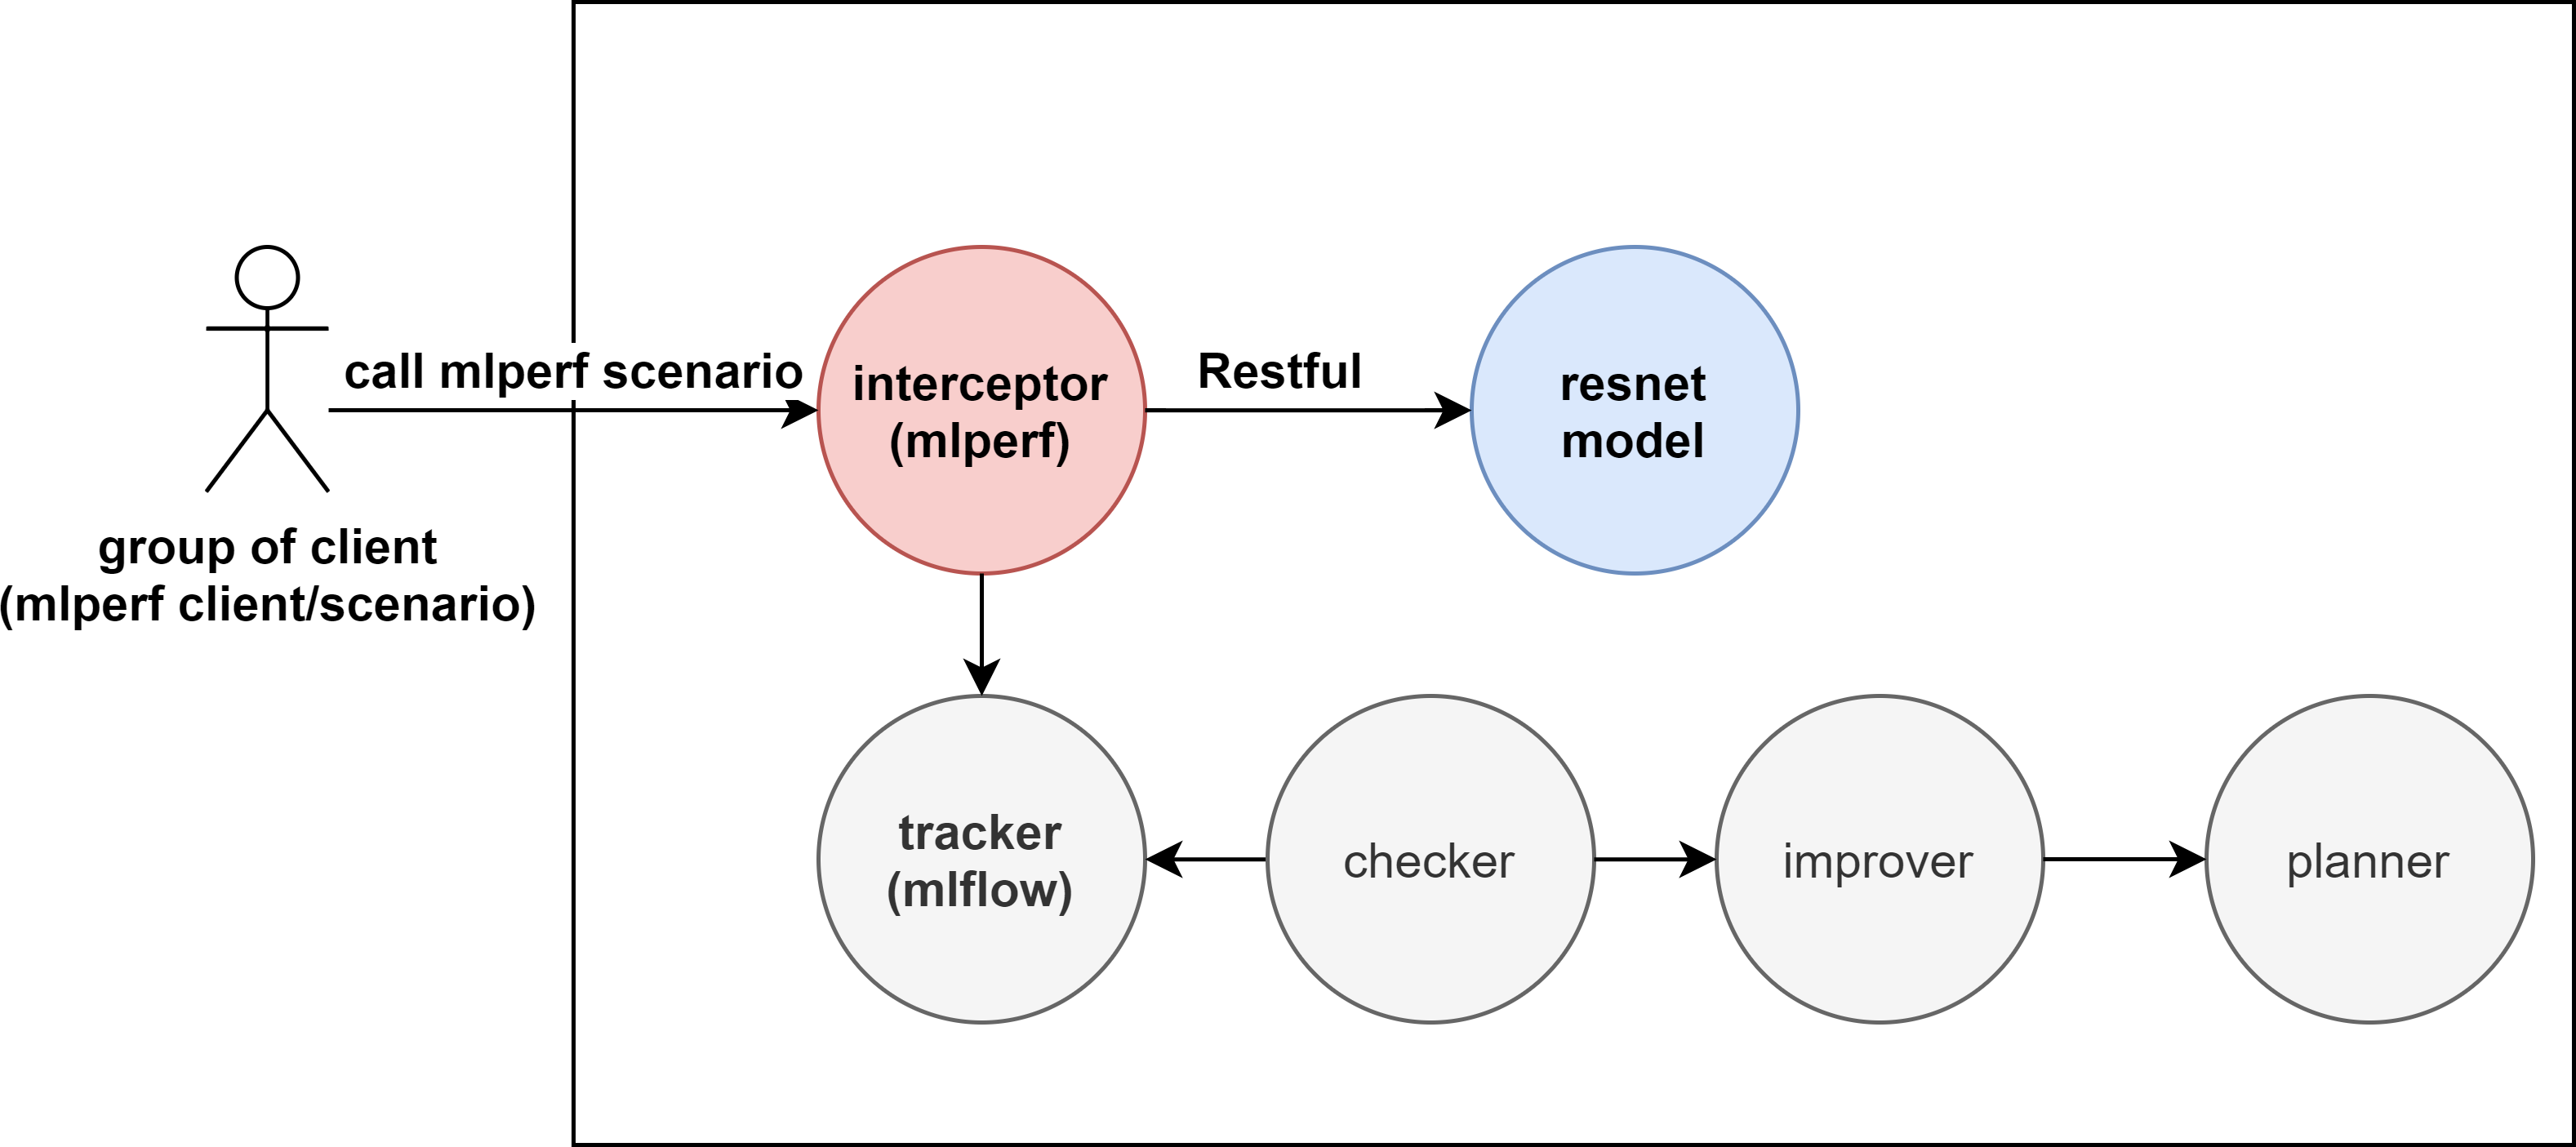

In [1]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/inference/images/inference.png", width=800, height=400)

## 1. Serve the model by using tfserving

In [ ]:
# download resnet model
mkdir /tmp/resnet
curl -s http://download.tensorflow.org/models/official/20181001_resnet/savedmodels/resnet_v2_fp32_savedmodel_NHWC_jpg.tar.gz | \
tar --strip-components=2 -C /tmp/resnet -xvz

#copy the model into tensorflow/serving
docker run -d --name serving_base tensorflow/serving
docker cp /tmp/resnet serving_base:/models/resnet
docker commit --change "ENV MODEL_NAME resnet" serving_base \
  172.30.0.49:5000/tensorflow-serving/resnet
    
#deploy on k8s - restnet service with 3 backend
apiVersion: apps/v1
kind: Deployment
metadata:
  name: resnet-deployment
spec:
  selector:
    matchLabels:
      app: resnet-server
  replicas: 3
  template:
    metadata:
      labels:
        app: resnet-server
    spec:
      containers:
      - name: resnet-container
        image: 172.30.0.49:5000/tensorflow-serving/resnet
        ports:
        - containerPort: 8500
---
apiVersion: v1
kind: Service
metadata:
  labels:
    run: resnet-service
  name: resnet-service
spec:
  ports:
  - port: 8500
    targetPort: 8501
    nodePort: 31930
  selector:
    app: resnet-server
  type: NodePort

## 2. mlperf as group of client + interceptor

usage: run_local.sh tf|onnxruntime|pytorch|tflite|tfserving [resnet50|mobilenet|ssd-mobilenet|ssd-resnet34] [cpu|gpu]

code: https://github.com/peiniliu/inference/tree/dev

In [ ]:
#build interceptor mount mlperf&data
docker build -f Dockerfile.modified.cpu -t 172.30.0.49:5000/interceptor .

    
#deploy on k8s - pod
apiVersion: v1
kind: PersistentVolume
metadata:
  name: data-path
  labels:
    type: local
spec:
  storageClassName: local-path
  capacity:
    storage: 10Gi
  accessModes:
    - ReadWriteMany
  hostPath:
    path: "/gpfs/bsc_home/xpliu/inference"
---
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: data-path
spec:
  storageClassName: local-path
  accessModes:
    - ReadWriteMany
  resources:
    requests:
      storage: 10Gi
---
apiVersion: v1
kind: Pod
metadata:
  name: interceptor-pod
  labels:
    app: interceptor-pod
spec:
  volumes:
  - name: data-path
    persistentVolumeClaim:
      claimName: data-path
  - name: tracker
    persistentVolumeClaim:
      claimName: resnettracker
  containers:
  - name: interceptor-pod
    image: 172.30.0.49:5000/interceptor
    imagePullPolicy: Always
    command: [ "/bin/bash", "-c", "--" ]
    args: [ "while true; do sleep 30; done;" ]
    env:
      - name: MLFLOW_TRACKING_URI
        value: http://tracker-service:8080
    volumeMounts:
      - name: data-path
        mountPath: /root
      - name: tracker
        mountPath: /mlflow

## 3. track information from interceptor

In [ ]:
# start scanflow-online tracker
http://172.30.0.50:30010/#/
# log metrics, artifacts

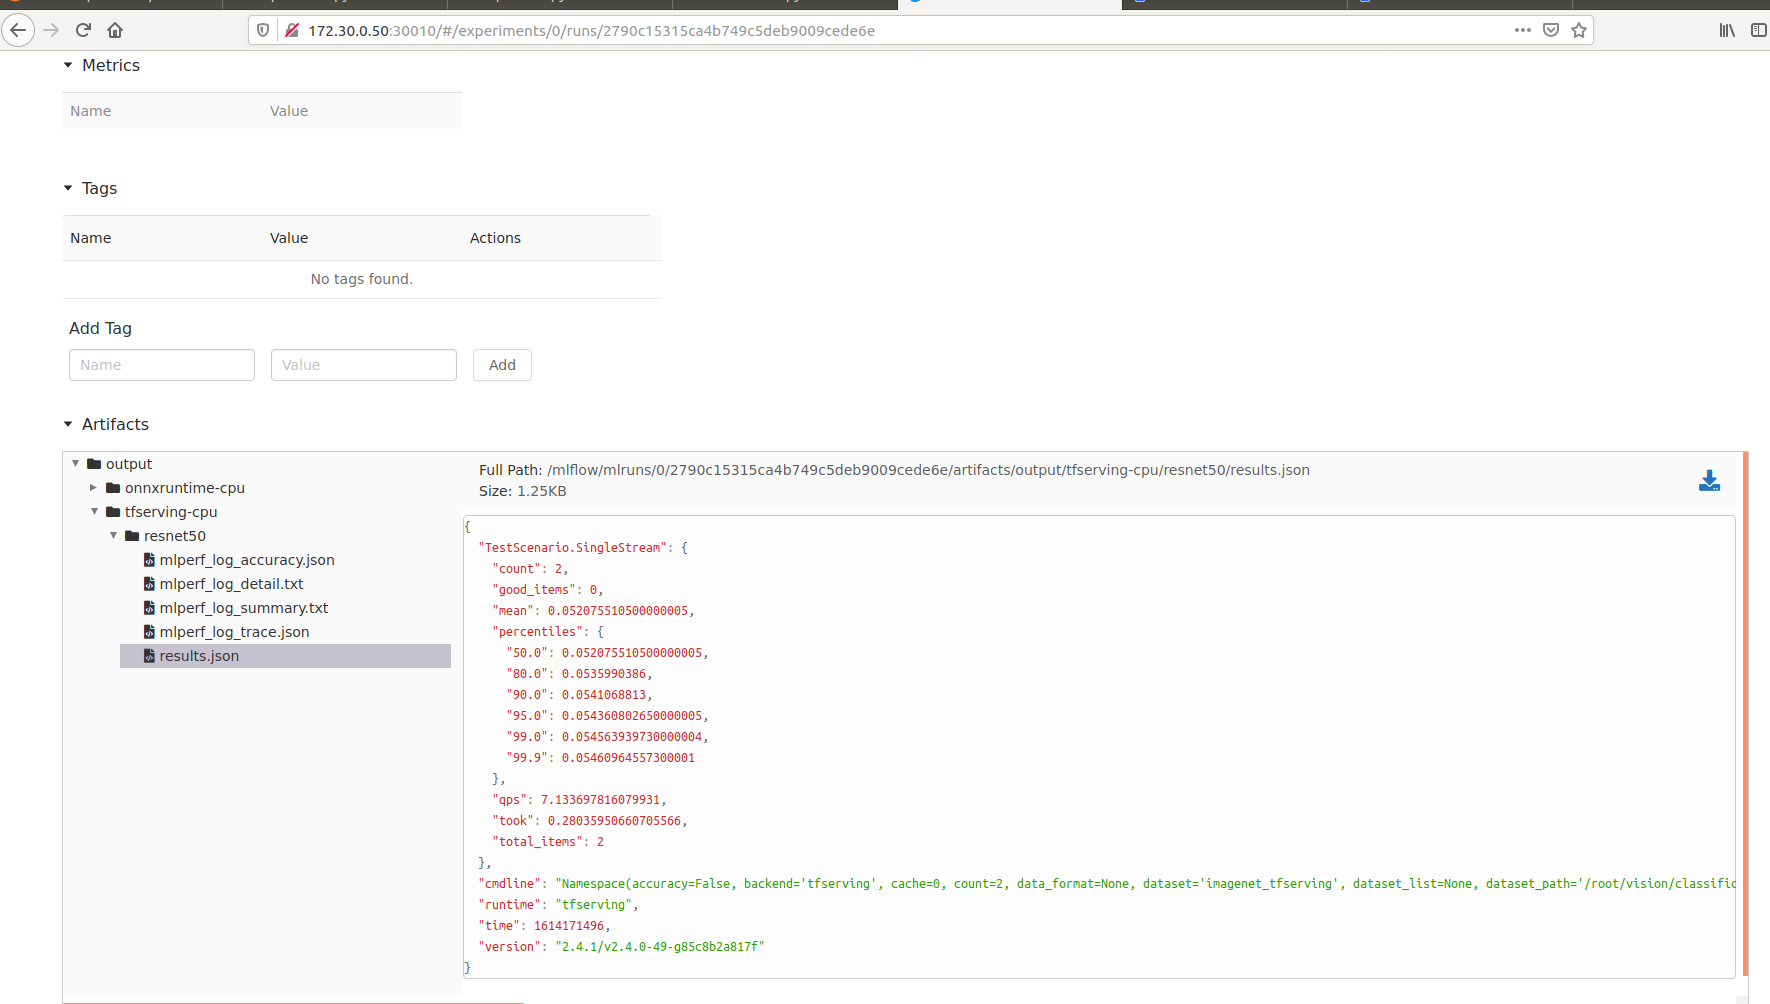

In [2]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/inference/images/mlflow-artifacts.PNG", width=800, height=400)